In [1]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.3 MB/s eta 0:00:00


In [2]:
import mne
import numpy as np

In [3]:
raw_edf = mne.io.read_raw_edf('matrix_eeg_stack10.edf', preload=True)

Extracting EDF parameters from /content/matrix_eeg_stack10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-3-30ea629c1212>:1: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw_edf = mne.io.read_raw_edf('/content/matrix_eeg_stack10.edf', preload=True)


Reading 0 ... 202499  =      0.000 ...   404.998 secs...


In [4]:
raw_edf.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F3, Fz, F4, F7, F8, FC3, FCz, FC4, FT7, FT8, C3, ...
 chs: 31 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-07-17 20:30:14 UTC
 nchan: 31
 projs: []
 sfreq: 500.0 Hz
 subject_info: 3 items (dict)
>

In [5]:
# 19 channels from 10-20. no A1 and A2 here
# Be careful. Pure 10-20 labeling differs from high-resolution montages
# In MNE, 10-20 montage is actually an extended high-resulution version of 10-20
# FYI, mapping from pure 10-20 to high-resolution versions
# T3 = T7
# T4 = T8
# T5 = P7
# T6 = P8

channels_to_use = [
    # prefrontal
    'Fp1',
    'Fp2',
    # frontal
    'F7',
    'F3',
    'F4',
    'Fz',
    'F8',
    # central and temporal
    'T7',
    'C3',
    'Cz',
    'C4',
    'T8',
    # parietal
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    # occipital
    'O1',
    'O2',
]

In [6]:
raw_edf_ch = raw_edf.copy().pick_channels(channels_to_use)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-6-a741d9722cbd>:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in an error because the following channel names are missing:
['T7', 'T8', 'P7', 'P8']
Either fix your included names or explicitly pass ordered=False.
  raw_edf_ch = raw_edf.copy().pick_channels(channels_to_use)
<ipython-input-6-a741d9722cbd>:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_edf_ch = raw_edf.copy().pick_channels(channels_to_use)


In [7]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
len(ten_twenty_montage.ch_names)

94

In [8]:
ch_map = {ch.lower(): ch for ch in raw_edf_ch.ch_names}

In [9]:
ten_twenty_montage.ch_names = [ch_map[ch.lower()] if ch.lower() in ch_map else ch
                               for ch in ten_twenty_montage.ch_names]

In [10]:
raw_edf_ch.set_montage(ten_twenty_montage)

<RawEDF | matrix_eeg_stack10.edf, 15 x 202500 (405.0 s), ~23.2 MB, data loaded>

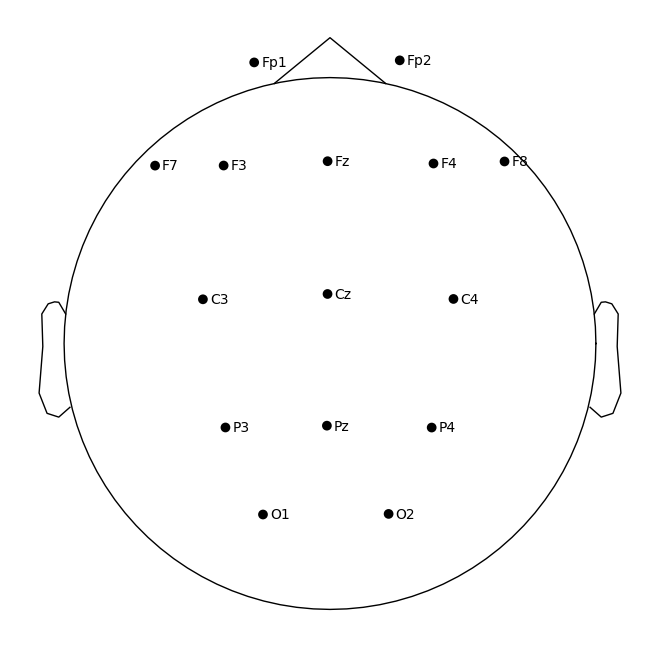

In [11]:
raw_edf_ch.plot_sensors(show_names=True);

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


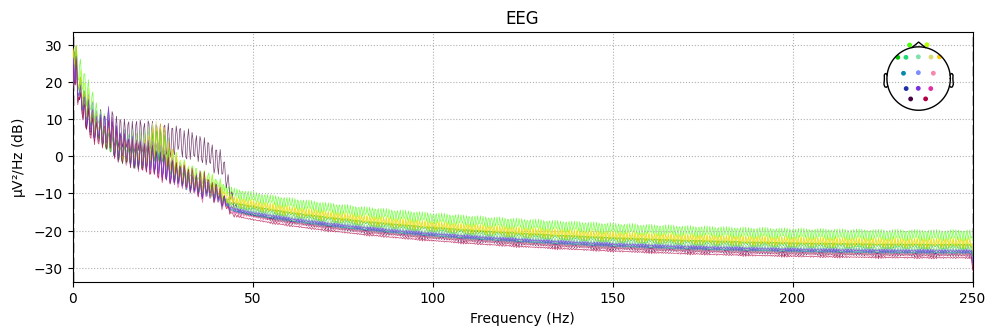

In [12]:
raw_edf_ch.plot_psd();

In [13]:
raw_edf_ch.filter(l_freq=1, h_freq=50, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB



<RawEDF | matrix_eeg_stack10.edf, 15 x 202500 (405.0 s), ~23.2 MB, data loaded>

In [14]:
ica = mne.preprocessing.ICA(n_components=len(raw_edf_ch.ch_names) - 1, random_state=42)

In [15]:
ica.fit(raw_edf_ch)

Fitting ICA to data using 15 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 18.6s.


Method,fastica
Fit,47 iterations on raw data (202500 samples)
ICA components,14
Available PCA components,15
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=14, n_times=202500
    Range : 0 ... 202499 =      0.000 ...   404.998 secs
Ready.


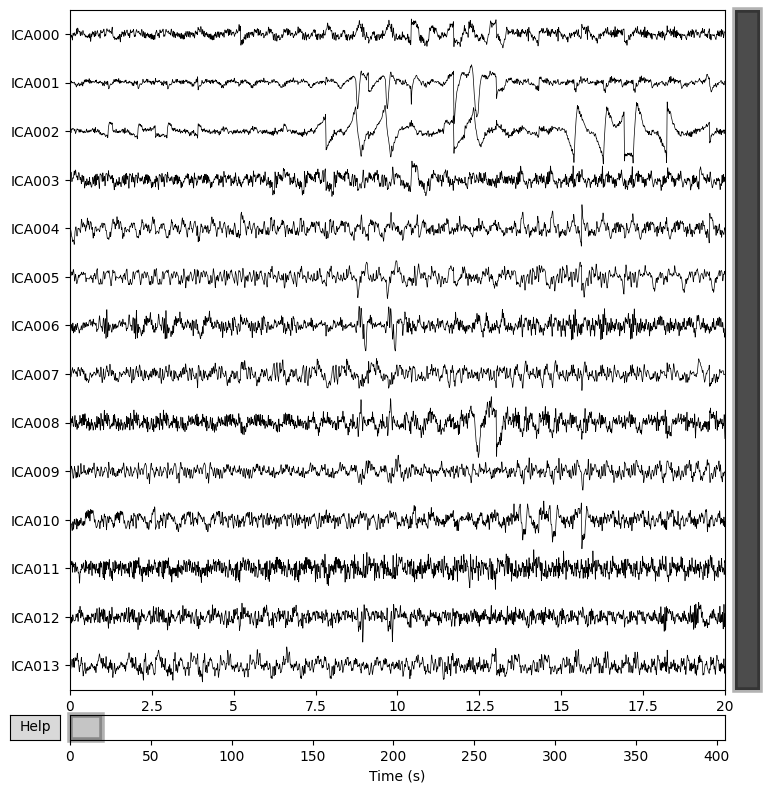

In [29]:
ica.plot_sources(raw_edf_ch);

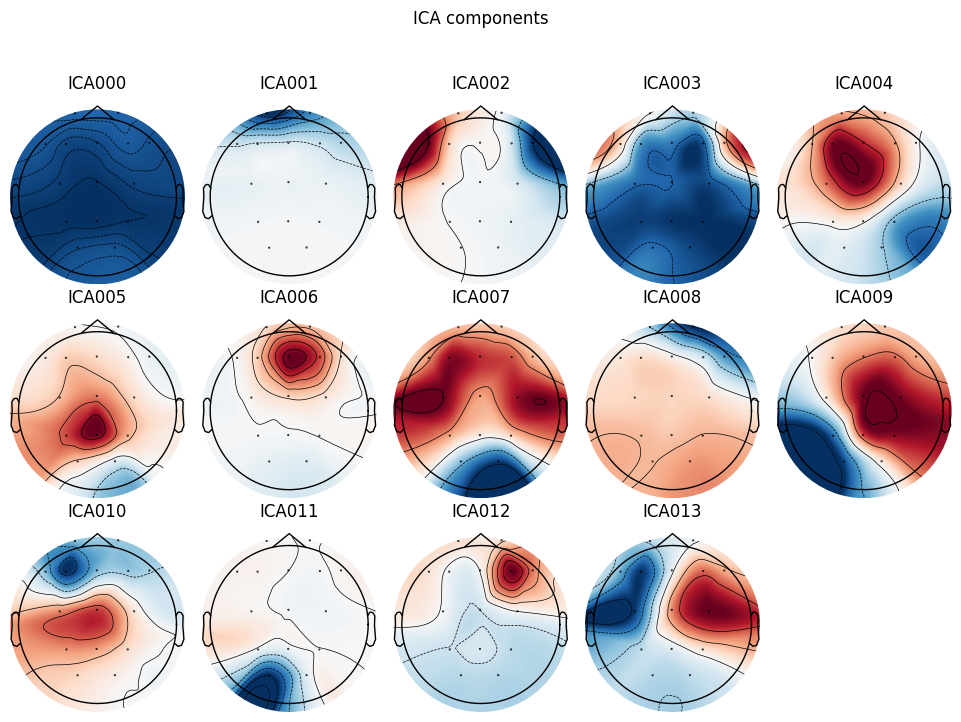

In [17]:
ica.plot_components();

Inspect ICA components more deeply. Check out spectrogram. Segments info is not very relevant here since we build ICA on the raw data.

We expect to see alpha and beta rythms picks on the spectrogram for good components (7-13 Hz and 13-30Hz respectively). And also slight decrease as frequency goes higher.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated


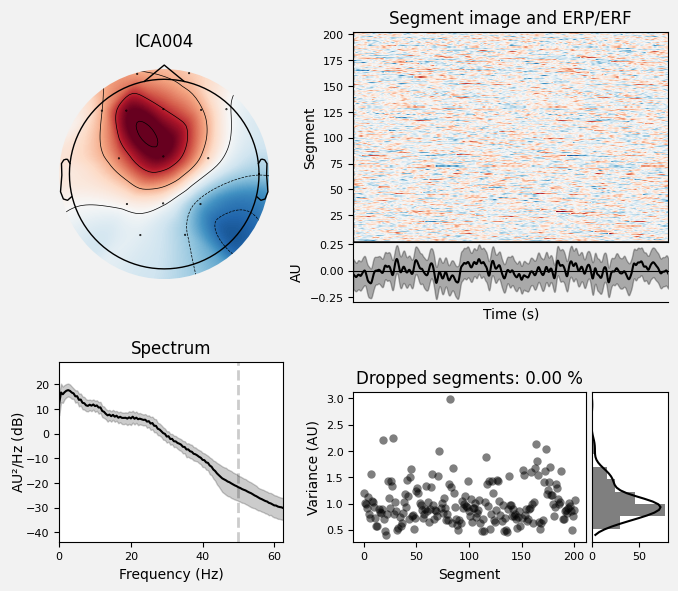

In [18]:
ica.plot_properties(raw_edf_ch, picks=[4]);

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 6 ICA components
    Projecting back using 15 PCA components


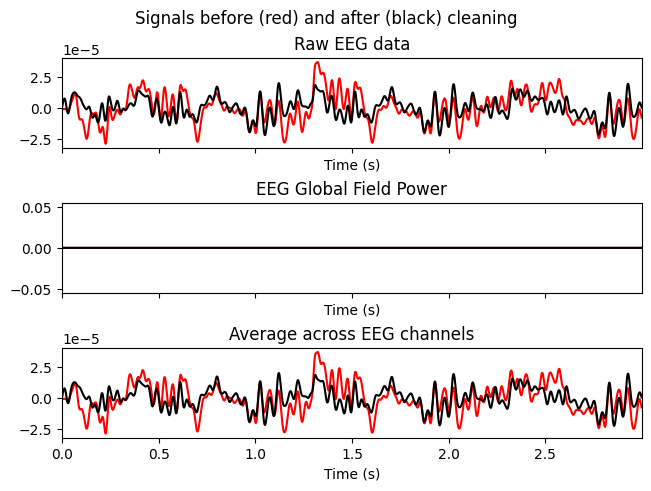

In [19]:
ica.plot_overlay(raw_edf_ch, exclude=[0, 1, 4, 5, 8, 9], picks=['F3']);

In [20]:
raw_ica_components = ica.get_components()
raw_ica_components.shape

(15, 14)

In [21]:
"""
  BEM is the acronym for boundary element method or boundary element model.
  Both are related to the definion of the conductor model in the forward model computation.
  The boundary element model consists of surfaces such as the inner skull, outer skull,
  and outer skin (scalp) that define compartments of tissues of the head.
"""

forw_model = mne.make_sphere_model(info=raw_edf_ch.info) # проекция сигналов нейронов на датчики на голове


Equiv. model fitting -> RV = 0.00349069 %
mu1 = 0.944696    lambda1 = 0.137201
mu2 = 0.667442    lambda2 = 0.683754
mu3 = -0.266813    lambda3 = -0.010585
Set up EEG sphere model with scalp radius    90.0 mm



In [22]:
cov = mne.make_ad_hoc_cov(info=raw_edf_ch.info, verbose=10) # бейзлайн; имеет смысл, когда есть события; диагональная матрица

In [23]:
cov

<Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

In [25]:
n_components = raw_ica_components.shape[1]
var_ratio_per_component = np.zeros(shape=n_components, dtype='float')

In [27]:
for component_idx in range(n_components):

  ica_component = raw_ica_components[:, [component_idx]]
  # Place the component in an Evoked object
  # The mne.Info object with information about the sensors and methods of measurement.
  component = mne.EvokedArray(ica_component, info=raw_edf_ch.info)
  component = component.set_eeg_reference(ref_channels="average")

  """
  evoked - List of channels,
  cov - List of channels to include (if empty include all available)
  bem - List of channels to exclude (if empty do not exclude any channel)
  Return dip - Indices of good channels - and residual - The M-EEG data channels with the fitted dipolar activity removed.
  """

  dip, residual = mne.fit_dipole(evoked=component, cov=cov, bem=forw_model, n_jobs=-1)

  residual_var = np.var(residual.to_data_frame().to_numpy(), axis=1) # a of shape (n_channels, n_times)

  component_var = np.var(component.to_data_frame().to_numpy(), axis=1) # a of shape (n_channels, n_times)

  var_ratio_per_component[component_idx] = np.sum(residual_var) / np.sum(component_var)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished


[done 249 sources]
No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    Using tolerance 1.3e-18 (2.2e-16 eps * 15 dim * 0.0004  max singular value)
    Estimated rank (eeg): 15
    EEG: rank 15 computed from 15 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 15 (0 small eigenvalues omitted)

---- Computing the forward solution for the guesses...
Making a spherical guess space with radius    81.0 mm...
Filtering (grid =     20 mm)...
Surface CM = (   0.0    0.0   40.0) mm
Surface fits inside a sphere with radius   81.0 mm
Surface extent:
    x =  -81.0 ...   81.0 mm
    y =  -81.0 ...   81.0 mm
    z =  -41.0 ...  121.0 mm
Grid extent:
    x = -100.0 ...  100.0 mm
    y = -100.0 ...  100.0 mm
    z =  -60.0 ...  140.0 mm
1331 sources before omitting any.
255 sources after omitting infeasible sources not within 20.0 - 81.0 mm.
249 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Go through all guess s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished


[done 249 sources]
No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



---- Computing the forward solution for the guesses...
Making a spherical guess space with radius    81.0 mm...
Filtering (grid =     20 mm)...
Surface CM = (   0.0    0.0   40.0) mm
Surface fits inside a sphere with radius   81.0 mm
Surface extent:
    x =  -81.0 ...   81.0 mm
    y =  -81.0 ...   81.0 mm
    z =  -41.0 ...  121.0 mm
Grid extent:
    x = -100.0 ...  100.0 mm
    y = -100.0 ...  100.0 mm
    z =  -60.0 ...  140.0 mm
1331 sources before omitting any.
255 sources after omitting infeasible sources not within 20.0 - 81.0 mm.
249 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Go through all guess source locations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished


[done 249 sources]
No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read  15 EEG channels from info
Head coordinate coil definitions created.
Decomposing the sensor noise covariance matrix...
Computing rank from covariance with rank=None
    Using tolerance 1.3e-18 (2.2e-16 eps * 15 dim * 0.0004  max singular value)
    Estimated rank (eeg): 15
    EEG: rank 15 computed from 15 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 15 (0 small eigenvalues omitted)

---- Computing the forward solution for the guesses...
Making a spherical guess space with radius    81.0 mm...
Filtering (grid =     20 mm)...
Surface CM = (   0.0    0.0   40.0) mm
Surface fits i

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished


No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read  15 EEG channels from info
Head coordinate coil definitions created.
Decomposing the sensor noise covariance matrix...
Computing rank from covariance with rank=None
    Using tolerance 1.3e-18 (2.2e-16 eps * 15 dim * 0.0004  max singular value)
    Estimated rank (eeg): 15
    EEG: rank 15 computed from 15 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 15 (0 small eigenvalues omitted)

---- Computing the forward solution for the guesses...
Making a spherical guess space with radius    81.0 mm...
Filtering (grid =     20 mm)...
Surface CM = (   0.0    0.0   40.0) mm
Surface fits inside a sphere with radius   81.0 mm
Surface extent:
    x =  -81.0 ...   81.0 mm
    y =  -81.0 ...   81.0 mm
    z =  -41.0 ...  121.0 mm
Grid extent:
    x = -100.0 ...  100.0 mm
    y = -100.0 ...  100.0 mm
    z =  -60.0 ...  140.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[done 249 sources]
No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[done 249 sources]
No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read  15 EEG channels from info
Head coordinate coil definitions created.
Decomposing the sensor noise covariance matrix...
Computing rank from covariance with rank=None
    Using tolerance 1.3e-1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[done 249 sources]


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished


[done 249 sources]
No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read  15 EEG channels from info
Head coordinate coil definitions created.
Decomposing the sensor noise covariance matrix...
Computing rank from covariance with rank=None
    Using tolerance 1.3e-18 (2.2e-16 eps * 15 dim * 0.0004  max singular value)
    Estimated rank (eeg): 15
    EEG: rank 15 computed from 15 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 15 (0 small eigenvalues omitted)

---- Computing the forward solution for the guesses..

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished


[done 249 sources]
No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
BEM               : <ConductorModel | Sphere (3 layers): r0=[0.0, 0.0, 40.0] R=90 mm>
MRI transform     : identity
Sphere model      : origin at (   0.00    0.00   40.00) mm, rad =    0.1 mm
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | diagonal : 15, n_samples : 0, data : [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14]>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000       0.00 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read  15 EEG channels from info
Head coordinate coil definitions created.
Decomposing the sensor noise covariance matrix...
Computing rank from covariance with rank=None
    Using tolerance 1.3e-18 (2.2e-16 eps * 15 dim * 0.0004  max singular value)
    Estimated rank (eeg): 15
    EEG: rank 15 computed from 15 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 15 (0 small eigenvalues omitted)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


No projector specified for this dataset. Please consider the method self.add_proj.
1 time points fitted


In [28]:
for i in range(n_components):
  print(f'component {i + 1}/{n_components}: var_ratio = {var_ratio_per_component[i]}')

component 1/14: var_ratio = 0.15823071774890143
component 2/14: var_ratio = 0.10571904895070633
component 3/14: var_ratio = 0.11342501514829567
component 4/14: var_ratio = 0.2615370330170093
component 5/14: var_ratio = 0.08424934618574756
component 6/14: var_ratio = 0.10754512830749864
component 7/14: var_ratio = 0.06255187157544442
component 8/14: var_ratio = 0.16172957307832234
component 9/14: var_ratio = 0.03321817832504677
component 10/14: var_ratio = 0.025795617116557423
component 11/14: var_ratio = 0.029196785338224236
component 12/14: var_ratio = 0.017031948955141193
component 13/14: var_ratio = 0.09343641994146987
component 14/14: var_ratio = 0.05900167784209708


In [35]:
well_fitted_component_idx =  np.argmin(var_ratio_per_component)
well_fitted_component_idx

11

In [37]:
worse_fitted_component_idx = np.argmax(var_ratio_per_component)
worse_fitted_component_idx

3

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated


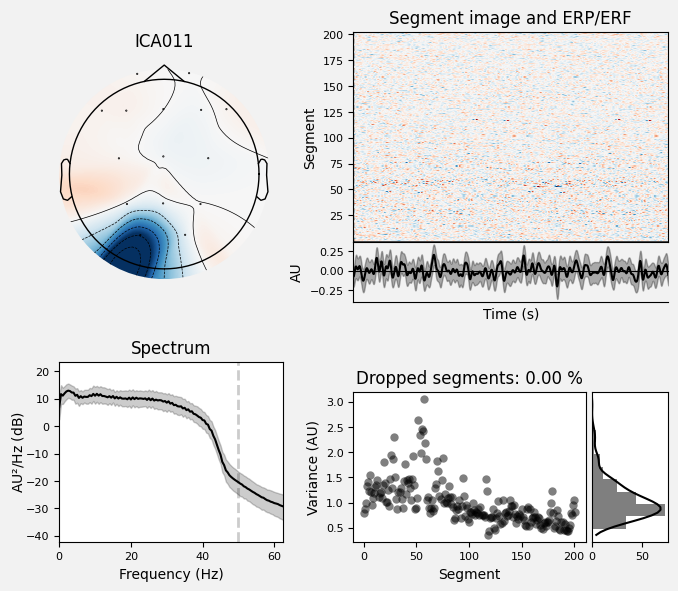

[<Figure size 700x600 with 6 Axes>]

In [54]:
ica.plot_properties(raw_edf_ch, \
                    picks=[well_fitted_component_idx],
                    dB=True, \
                    plot_std=True, \
                    show=True, \
                    topomap_args={'title': f'Component {well_fitted_component_idx + 1}/{n_components}: var_ratio={var_ratio_per_component[well_fitted_component_idx]}'} \
)

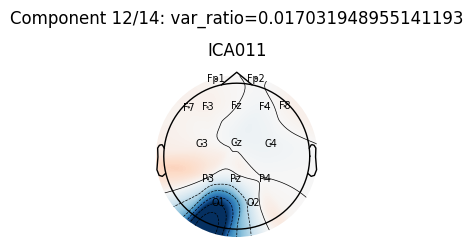

In [48]:
ica.plot_components(picks=[well_fitted_component_idx], \
                    plot_std=True, show_names=True, \
                    title=f'Component {well_fitted_component_idx + 1}/{n_components}: var_ratio={var_ratio_per_component[well_fitted_component_idx]}', \
                    show=True);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated


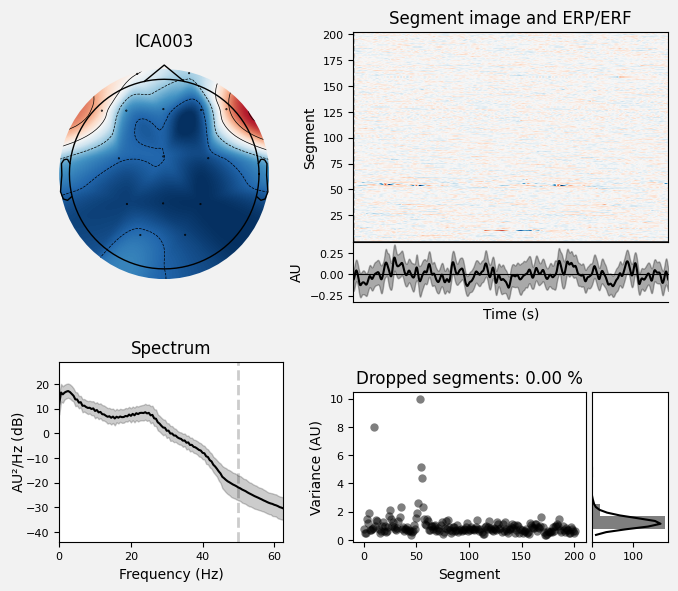

[<Figure size 700x600 with 6 Axes>]

In [55]:
ica.plot_properties(raw_edf_ch, \
                    picks=[worse_fitted_component_idx],
                    dB=True, \
                    plot_std=True, \
                    show=True, \
                    topomap_args={'title': f'Component {worse_fitted_component_idx + 1}/{n_components}: var_ratio={var_ratio_per_component[worse_fitted_component_idx]}'} \
)

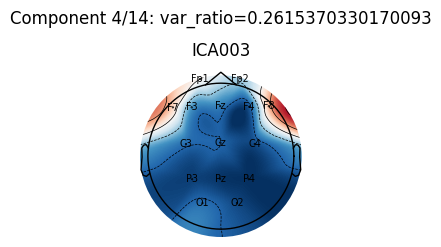

In [47]:
ica.plot_components(picks=[worse_fitted_component_idx], \
                    plot_std=True, show_names=True, \
                    title=f'Component {worse_fitted_component_idx + 1}/{n_components}: var_ratio={var_ratio_per_component[worse_fitted_component_idx]}', \
                    show=True);

# Current dipole fitting using independent components

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.7 MB/s eta 0:00:00


In [ ]:
import mne

Grab some example data

In [ ]:
"""
Get path to local copy of sample dataset.
path=None => the environment variable or config parameter MNE_DATASETS_SAMPLE_PATH is used.
If it doesn’t exist, the “~/mne_data” directory is used.
If the sample dataset is not found under the given path, the data will be automatically downloaded to the specified folder.
"""
root = mne.datasets.sample.data_path()
subjects_dir = root / 'subjects'
meg_dir = root / 'MEG' / 'sample'

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 241GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 02m25s (1576.2 MB)


In [ ]:
raw = mne.io.read_raw_fif(meg_dir / 'sample_audvis_filt-0-40_raw.fif', preload=True) # Raw data in FIF format, preloaded to memory

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [ ]:
raw.info

<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>

In [ ]:
raw.info['bads']

['MEG 2443', 'EEG 053']

In [ ]:
raw.drop_channels(raw.info['bads'])

<Raw | sample_audvis_filt-0-40_raw.fif, 374 x 41700 (277.7 s), ~122.3 MB, data loaded>

Compute covariance

In [ ]:
events = mne.find_events(raw) # Events correspond to specific time points in raw data, such as triggers, experimental condition events, etc.

319 events found
Event IDs: [ 1  2  3  4  5 32]


In [ ]:
epochs = mne.Epochs(raw, events, event_id={'aud/l': 1, 'aud/r': 2, 'vis/l': 3, 'vis/r': 4}, picks='meg', preload=True)

Not setting metadata
288 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Using data from preloaded Raw for 288 events and 106 original time points ...
0 bad epochs dropped


In [ ]:
cov = mne.read_cov(meg_dir / 'sample_audvis-cov.fif') # Read a noise covariance from a FIF file

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active


In [ ]:
# Hipass before fitting ICA
raw_high = raw.filter(1.0, None) # Filter a subset of channels: the data are only high-passed

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.7s


In [ ]:
# Tuning ICA for speed over accuracy for this example
# Run the ICA decomposition on raw data: raw_high - data to be decomposed, decim - increment for selecting only each n-th sampling point, picks - channels to include
ica = mne.preprocessing.ICA(0.9, random_state=0).fit(raw_high, decim=5, picks='meg')

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Selecting by explained variance: 70 components
Fitting ICA took 30.8s.


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


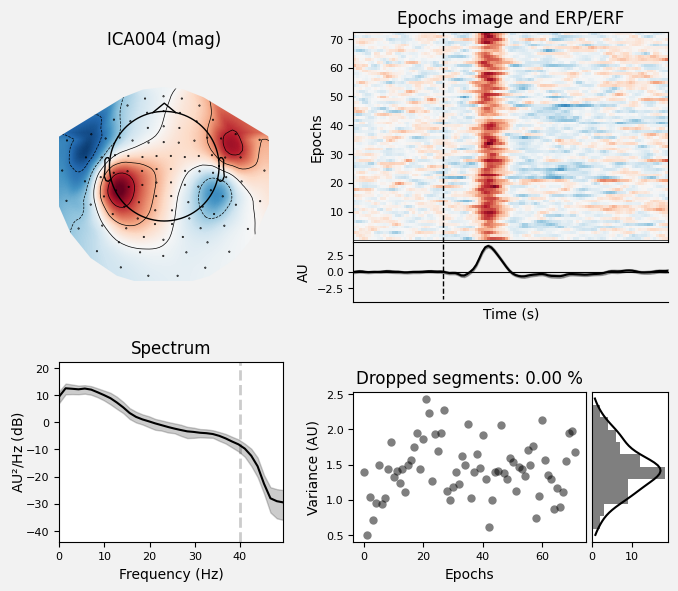

[<Figure size 700x600 with 6 Axes>]

In [ ]:
# Let's look through the components to see if there's one with a nice dipole pattern...
# Component 4 looks good! It seems to capture the auditory evoked potential.
# Display component properties. Properties include the topography, epochs image, ERP/ERF, power spectrum, and epoch variance.
ica.plot_properties(epochs['aud/l'], picks=4) # picks - indices of the independent components (ICs) to visualize

In [ ]:
# Place the component in an Evoked object
component = mne.EvokedArray(ica.get_components()[:, [4]], info=epochs.info) # The mne.Info object with information about the sensors and methods of measurement.

In [ ]:
# Load a BEM model and fit a dipole
"""
BEM is the acronym for boundary element method or boundary element model.
Both are related to the definion of the conductor model in the forward model computation.
The boundary element model consists of surfaces such as the inner skull, outer skull,
and outer skin (scalp) that define compartments of tissues of the head.
"""
bem = mne.read_bem_solution(subjects_dir / 'sample' / 'bem' / 'sample-5120-5120-5120-bem-sol.fif')

In [ ]:
# The transformation dictionary from the fif file
trans = mne.read_trans(meg_dir / 'sample_audvis_raw-trans.fif')

In [ ]:
# Fit the dipole using only the sensors on the left side of the head
picks_lh = [ch['ch_name'] for ch in epochs.info['chs'] if ch['loc'][0] < 0]

In [ ]:
component_lh = component.pick_channels(picks_lh)

In [ ]:
"""
component_lh - List of channels,
cov - List of channels to include (if empty include all available)
bem - List of channels to exclude (if empty do not exclude any channel)
trans - If True (default False), ensure that the order of the channels in the modified instance matches the order of ch_names

Return Indices of good channels.
"""
dip, _ = mne.fit_dipole(component_lh, cov, bem, trans)

In [ ]:
# Plot dipole location
dip.plot_locations(trans, 'sample', subjects_dir)

# Source localization with equivalent current dipole (ECD) fit

This shows how to fit a dipole 1 using MNE-Python.

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install mne
!pip install nilearn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.forward import make_forward_dipole
from mne.evoked import combine_evoked
from mne.simulation import simulate_evoked

from nilearn.plotting import plot_anat
from nilearn.datasets import load_mni152_template

In [ ]:
"""
Get path to local copy of sample dataset.
path=None => the environment variable or config parameter MNE_DATASETS_SAMPLE_PATH is used.
If it doesn’t exist, the “~/mne_data” directory is used.
If the sample dataset is not found under the given path, the data will be automatically downloaded to the specified folder.
"""

data_path = mne.datasets.sample.data_path()
subjects_dir = data_path / "subjects"
fname_ave = data_path / "MEG" / "sample" / "sample_audvis-ave.fif"
fname_cov = data_path / "MEG" / "sample" / "sample_audvis-cov.fif"
fname_bem = subjects_dir / "sample" / "bem" / "sample-5120-bem-sol.fif"
fname_trans = data_path / "MEG" / "sample" / "sample_audvis_raw-trans.fif"
fname_surf_lh = subjects_dir / "sample" / "surf" / "lh.white"

Let’s localize the N100m (using MEG only)

In [ ]:
# Read evoked dataset(s)
"""
condition - The index or list of indices of the evoked dataset to read. FIF files can contain multiple datasets
baseline - The time interval to consider as “baseline” when applying baseline correction.
If a tuple (a, b), the interval is between a and b (in seconds), including the endpoints.
If a is None, the beginning of the data is used;
"""
evoked = mne.read_evokeds(fname_ave, condition="Right Auditory", baseline=(None, 0))

Reading /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Right Auditory)
        0 CTF compensation matrices available
        nave = 61 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)


In [ ]:
# Pick some channels by type and names
evoked.pick_types(meg=True, eeg=False) # include MEG channels and exclude EEG channels

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


<Evoked | 'Right Auditory' (average, N=61), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 305 ch, ~4.2 MB>

In [ ]:
evoked_full = evoked.copy()
evoked.crop(0.07, 0.08) # Crop data to a given time interval.

<Evoked | 'Right Auditory' (average, N=61), 0.069928 – 0.079918 s, baseline -0.199795 – 0 s (baseline period was cropped after baseline correction), 305 ch, ~3.2 MB>

In [ ]:
# Fit a dipole
"""
evoked - List of channels,
fname_cov - List of channels to include (if empty include all available)
fname_bem - List of channels to exclude (if empty do not exclude any channel)
fname_trans - If True (default False), ensure that the order of the channels in the modified instance matches the order of ch_names

Return Indices of good channels.
"""
dip = mne.fit_dipole(evoked, fname_cov, fname_bem, fname_trans)[0]

BEM               : PosixPath('/root/mne_data/MNE-sample-data/subjects/sample/bem/sample-5120-bem-sol.fif')
MRI transform     : /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Head origin       :   -4.3   18.4   67.0 mm rad =   71.8 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis-cov.fif

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -0.173570  0.977991      64.74 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read 305 MEG channels from info
1

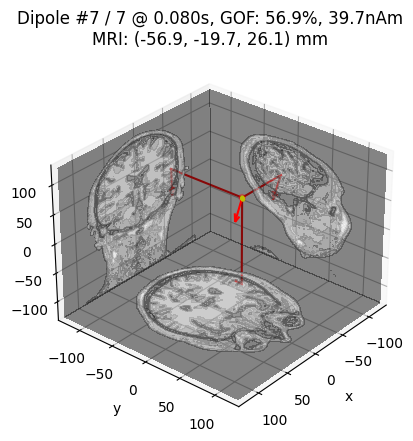

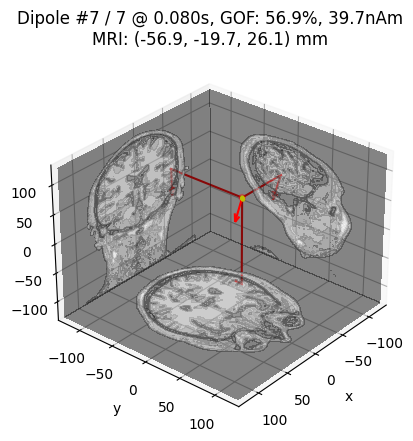

In [ ]:
# Plot the result in 3D brain with the MRI image.
dip.plot_locations(fname_trans, "sample", subjects_dir, mode="orthoview")

We can also plot the result using outlines of the head and brain.

In [ ]:
color = ["k"] * len(dip)
color[np.argmax(dip.gof)] = "r"

Using lh.seghead for head surface.


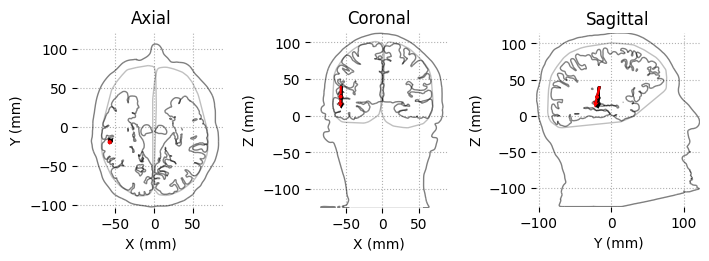

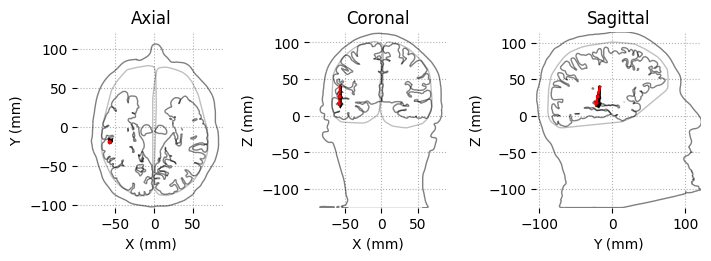

In [ ]:
dip.plot_locations(fname_trans, "sample", subjects_dir, mode="outlines", color=color)

Plot the result in 3D brain with the MRI image using Nilearn In MRI coordinates and in MNI coordinates (template brain)

In [ ]:
subject = "sample"

In [ ]:
mni_pos = dip.to_mni(subject=subject, trans=fname_trans, subjects_dir=subjects_dir)

In [ ]:
mri_pos = dip.to_mri(subject=subject, trans=fname_trans, subjects_dir=subjects_dir)

In [ ]:
# Find an anatomical label for the best fitted dipole
best_dip_idx = dip.gof.argmax()
label = dip.to_volume_labels(
    fname_trans, subject=subject, subjects_dir=subjects_dir, aseg="aparc.a2009s+aseg"
)[best_dip_idx]

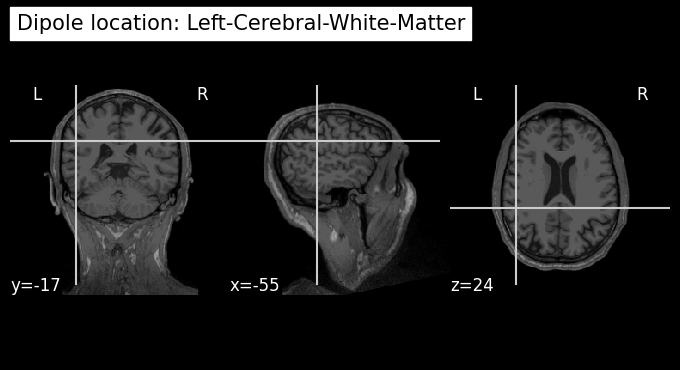

In [ ]:
# Draw dipole position on MRI scan and add anatomical label from parcellation
t1_fname = subjects_dir / subject / "mri" / "T1.mgz"
fig_T1 = plot_anat(t1_fname, cut_coords=mri_pos[0], title=f"Dipole location: {label}")

In [ ]:
try:
    template = load_mni152_template(resolution=1)
except TypeError:  # in nilearn < 0.8.1 this did not exist
    template = load_mni152_template()

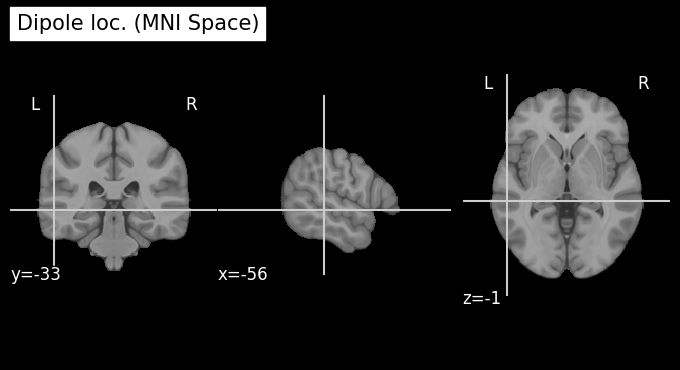

In [ ]:
fig_template = plot_anat(
    template, cut_coords=mni_pos[0], title="Dipole loc. (MNI Space)"
)

Calculate and visualise magnetic field predicted by dipole with maximum GOF and compare to the measured data, highlighting the ipsilateral (right) source

In [ ]:
fwd, stc = make_forward_dipole(dip, fname_bem, evoked.info, fname_trans)

Positions (in meters) and orientations
7 sources
Source space          : <SourceSpaces: [<discrete, n_used=7>] head coords, ~3 kB>
MRI -> head transform : /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data      : instance of Info
Conductor model   : /root/mne_data/MNE-sample-data/subjects/sample/bem/sample-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 7 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00

Read 305 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -0.173570  0.977991      64.74 mm

In [ ]:
pred_evoked = simulate_evoked(fwd, stc, evoked.info, cov=None, nave=np.inf)

Projecting source estimate to sensor space...
[done]


In [ ]:
# find time point with highest GOF to plot
best_idx = np.argmax(dip.gof)
best_time = dip.times[best_idx]

In [ ]:
print(
    "Highest GOF %0.1f%% at t=%0.1f ms with confidence volume %0.1f cm^3"
    % (dip.gof[best_idx], best_time * 1000, dip.conf["vol"][best_idx] * 100**3)
)

Highest GOF 56.9% at t=79.9 ms with confidence volume 8.1 cm^3


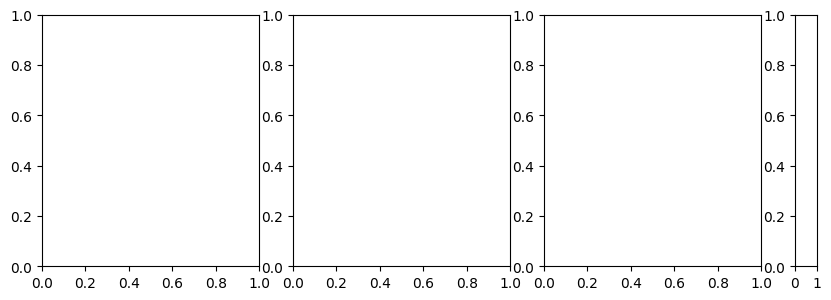

In [ ]:
# remember to create a subplot for the colorbar
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=[10.0, 3.4],
    gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1], top=0.85),
)

In [ ]:
vmin, vmax = -400, 400  # make sure each plot has same colour range

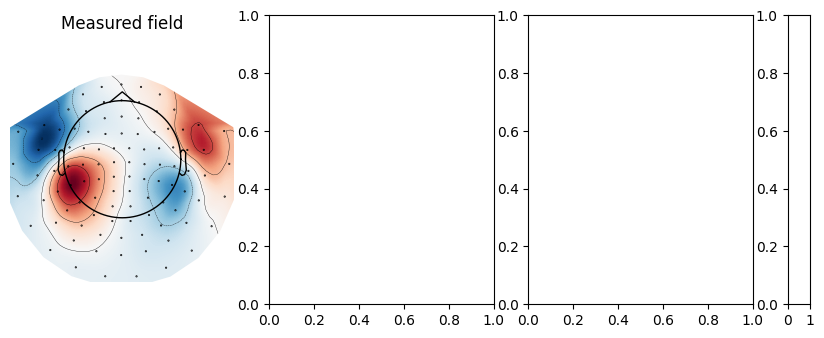

In [ ]:
# first plot the topography at the time of the best fitting (single) dipole
plot_params = dict(times=best_time, ch_type="mag", outlines="head", colorbar=False)
evoked.plot_topomap(time_format="Measured field", axes=axes[0], **plot_params)

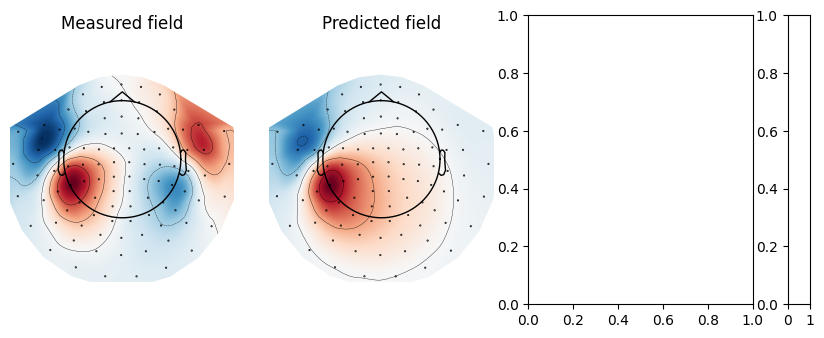

In [ ]:
# compare this to the predicted field
pred_evoked.plot_topomap(time_format="Predicted field", axes=axes[1], **plot_params)

In [ ]:
# Subtract predicted from measured data (apply equal weights)
diff = combine_evoked([evoked, pred_evoked], weights=[1, -1])
plot_params["colorbar"] = True
diff.plot_topomap(time_format="Difference", axes=axes[2:], **plot_params)
fig.suptitle(
    "Comparison of measured and predicted fields "
    "at {:.0f} ms".format(best_time * 1000.0),
    fontsize=16,
)
fig.tight_layout()

<ipython-input-44-25c40605bb7d>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Estimate the time course of a single dipole with fixed position and orientation (the one that maximized GOF) over the entire interval

In [ ]:
dip_fixed = mne.fit_dipole(
    evoked_full,
    fname_cov,
    fname_bem,
    fname_trans,
    pos=dip.pos[best_idx],
    ori=dip.ori[best_idx],
)[0]

BEM               : PosixPath('/root/mne_data/MNE-sample-data/subjects/sample/bem/sample-5120-bem-sol.fif')
MRI transform     : /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Head origin       :   -4.3   18.4   67.0 mm rad =   71.8 mm.
Fixed position    :  -61.1    5.3   59.6 mm
Fixed orientation  : 0.0113 -0.7506 -0.6606 mm
Noise covariance  : /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis-cov.fif

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -0.173570  0.977991      64.74 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read 305 MEG channels from info
105 coil definitions read
Coordinat

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s


Projections have already been applied. Setting proj attribute to True.
421 time points fitted


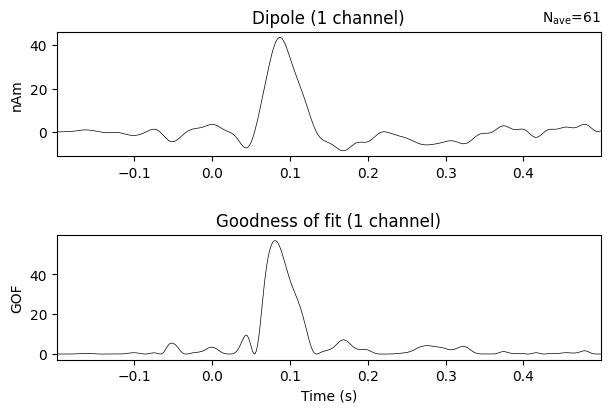

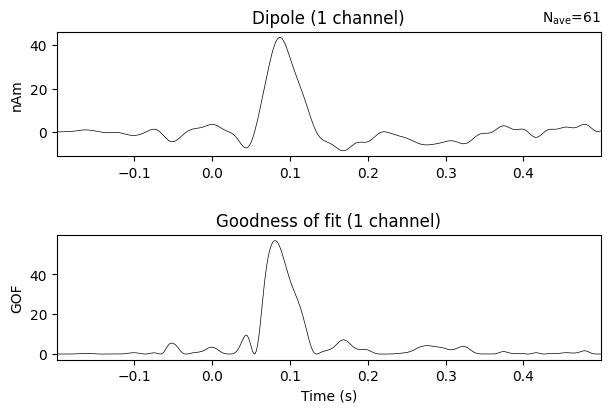

In [ ]:
dip_fixed.plot()